In [13]:
#Import standard scientific computing packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

#The OS Package allows you to put together directory strings regardless of the OS you're using
import os

#Import flopy 
import flopy

#Packages for dealing with Raster geospatial data
import rasterio
import rasterio.plot

#Packages for dealing with vector geospatial data
import geopandas as gpd

def combined_gridplot(modelgrid_in,cross_type="row", cross_num=0,vert_exag=1):
    fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(10,10),height_ratios=[0.2,1])

    try:
        axs[0].set_aspect(vert_exag)
        pcr = flopy.plot.PlotCrossSection(modelgrid=modelgrid_in, ax=axs[0], line={cross_type: cross_num}, geographic_coords=True)
        pcr.plot_grid(lw=0.5)
        if cross_type=="row":
            axs[0].set_xlabel('x')
        elif cross_type=="column":
            axs[0].set_xlabel('y')
        axs[0].set_ylabel('z')
        axs[0].set_title(f'Cross-section through {cross_type} {cross_num}, Vertical Exag = {vert_exag}')
    except:
        print('Cross-section could not be generated. Check inputs')
        pcr = None
    
    axs[1].set_aspect(1)
    pmv = flopy.plot.PlotMapView(modelgrid=modelgrid_in, ax=axs[1])
    pmv.plot_grid(lw=0.5)
    axs[1].set_xlabel('x')
    axs[1].set_ylabel('y')
    axs[1].set_title(modelgrid_in)
    return fig, axs, [pcr, pmv]


In [2]:
data_path = os.path.join(".","data", "data_3-20")

(1,)
EPSG:26915


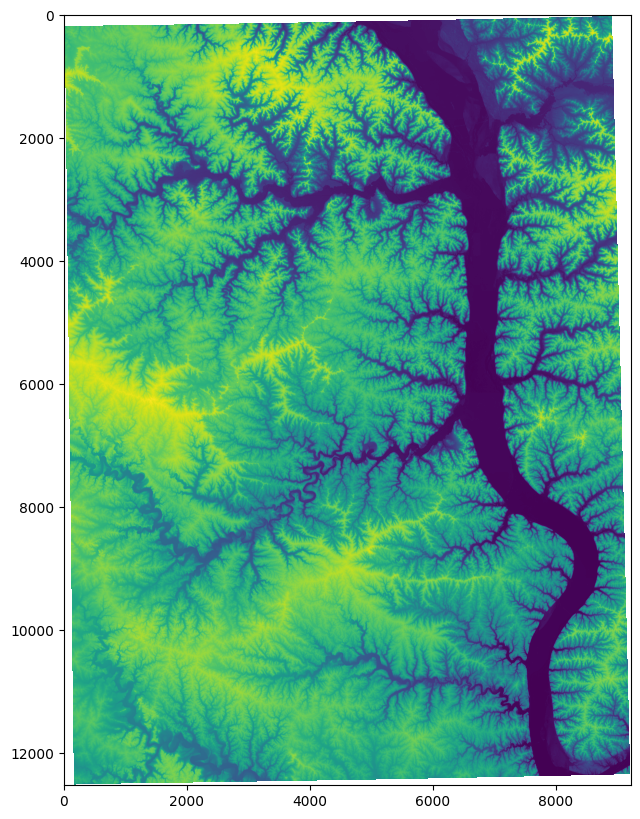

In [3]:
#Load and visualize DEM data
dem_file = os.path.join(data_path, "USGS_13_n44w092_20230210_reprojected.tif")
raster_dataset = rasterio.open(dem_file)
print(raster_dataset.indexes)
vals_masked = raster_dataset.read(1,masked=True)
np.min(vals_masked)

#Note - the DEM has been modified outside of Python to be in the right CRS
print(raster_dataset.crs)

figDEM,axDEM = plt.subplots(figsize=(10,10))
axDEM.set_aspect('equal')
axDEM.imshow(vals_masked)


<class 'geopandas.geodataframe.GeoDataFrame'>
EPSG:26915
<class 'geopandas.geodataframe.GeoDataFrame'>
EPSG:26915
<class 'geopandas.geodataframe.GeoDataFrame'>
EPSG:26915


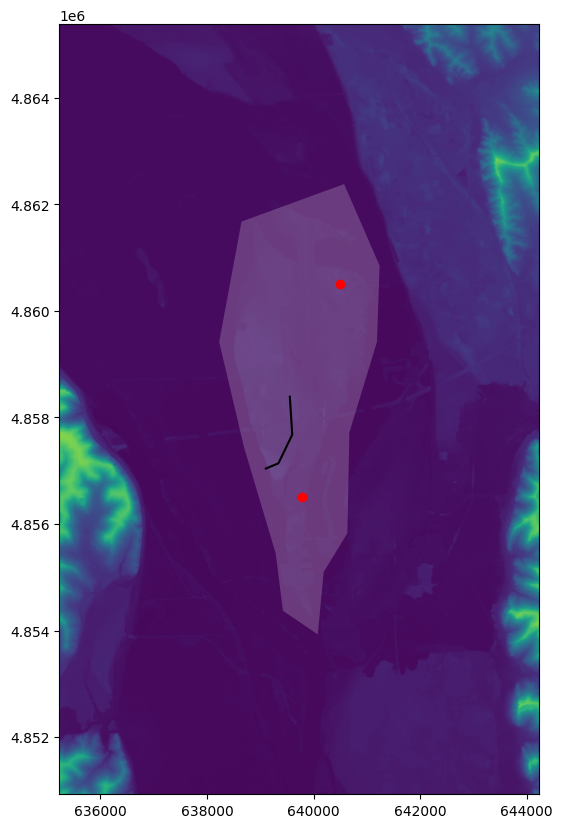

In [17]:
#Import and visualize shapefile data on top of DEM
modelbd_file = os.path.join(data_path,"Model_bounds.shp")
modelriv_file = os.path.join(data_path,"ex_river.shp")
modelwells_file = os.path.join(data_path,"wells_example.shp")
bound_shape_gpd = gpd.read_file(modelbd_file)
riv_shape_gpd = gpd.read_file(modelriv_file)
wells_shape_gpd = gpd.read_file(modelwells_file)

#Double-check the coordinate reference systems for the shapefiles
print(type(bound_shape_gpd))
print(bound_shape_gpd.crs)
print(type(riv_shape_gpd))
print(riv_shape_gpd.crs)
print(type(wells_shape_gpd))
print(wells_shape_gpd.crs)

figDEM,axDEM = plt.subplots(figsize=(10,10))
axDEM.set_aspect('equal')
#Add rasterio data to a plot using rasterio.plot
rasterio.plot.show(raster_dataset,ax=axDEM)
#Add vector data to a plot using methods of the GeoDataFrame (Geopandas variable class)
bound_shape_gpd.plot(ax=axDEM,color='white',alpha=0.2)
riv_shape_gpd.plot(ax=axDEM,color='black')
wells_shape_gpd.plot(ax=axDEM,color='red')

#Find the bounds, extend these a bit, and then use for plotting the locale
xybound = bound_shape_gpd.bounds
xmin, ymin, xmax, ymax = xybound.to_numpy()[0]
padding = 3000
axDEM.set_xlim(xmin-padding,xmax+padding)
axDEM.set_ylim(ymin-padding,ymax+padding)

celldx, celldy = 50, 50
xlen = xmax - xmin
ylen = ymax - ymin
numrows = int(np.ceil(ylen /  celldy))
numcols = int(np.ceil(xlen / celldx))
numcell_perlayer = numrows*numcols
dr = celldx*np.ones((numcols,))
dc = celldy*np.ones((numrows,))

modelgrid2D = flopy.discretization.StructuredGrid(
    delc=dc,
    delr=dr,
    xoff=xmin,
    yoff=ymin
    )

In [25]:
gx = flopy.utils.GridIntersect(modelgrid2D)

result = gx.intersect(bound_shape_gpd.loc[0,"geometry"])
print(result.dtype.names)

ibound = np.zeros((numrows, numcols))
#Note - this "star" notation here unpacks an array
i, j = zip(*result.cellids)
ibound[i,j] = 1

('cellids', 'vertices', 'areas', 'ixshapes')


In [28]:
riv_result = gx.intersect(riv_shape_gpd.loc[0,"geometry"])
print(riv_result.dtype.names)

riv_cells = np.zeros((numrows, numcols))
#Note - this "star" notation here unpacks an array
i, j = zip(*riv_result.cellids)
riv_cells[i,j] = 1

('cellids', 'vertices', 'lengths', 'ixshapes')


In [29]:
rows, cols = wells_shape_gpd.shape
well_cells = np.zeros((numrows,numcols))
for ind in range(rows):
    well_result = gx.intersect(wells_shape_gpd.loc[ind,"geometry"])
    print(well_result.dtype.names)
    i,j = zip(*well_result.cellids)
    well_cells[i,j] = 1
    print(wells_shape_gpd.loc[ind])

    

('cellids', 'ixshapes')
id                                                    1
well_name                                    well1_test
Q_rate                                           -100.0
geometry     POINT (639775.8668400898 4856505.85934327)
Name: 0, dtype: object
('cellids', 'ixshapes')
id                                                     2
well_name                                     well2_test
Q_rate                                             -50.0
geometry     POINT (640496.8137119039 4860512.264102351)
Name: 1, dtype: object


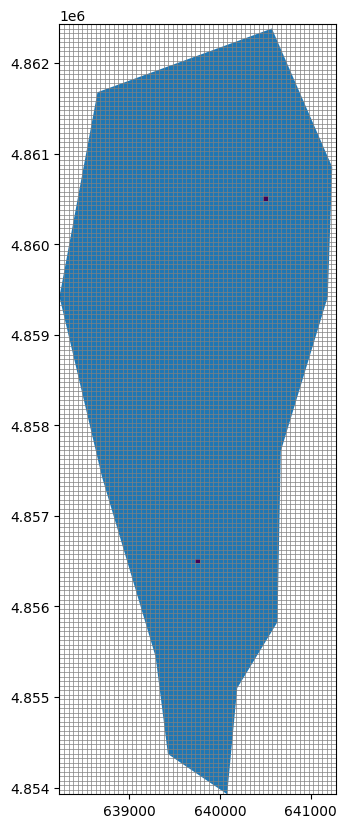

In [32]:
fig3,ax3 = plt.subplots(figsize=(10,10))
ax3.set_aspect('equal')

pmv = flopy.plot.PlotMapView(modelgrid=modelgrid2D, ax=ax3)
pmv.plot_grid(lw=0.5)
bound_shape_gpd.plot(ax=ax3)

#Each of these can be uncommented and plotted individually to see the affected cells
#pmv.plot_array(ibound, masked_values=[1], ax=ax3)
#pmv.plot_array(riv_cells,masked_values=[0],ax=ax3)
pmv.plot_array(well_cells,masked_values=[0],ax=ax3)


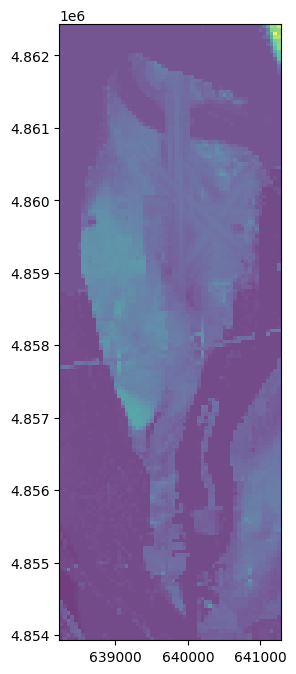

In [33]:

raster_test = flopy.utils.Raster.load(dem_file)

#Note - with this command you may get errors about packages including rasterstats. 
#These require a (somewhat finnicky) installation of GDAL. Installing it globally on
#my system using the alternative package manager "brew" was necessary in one case
dem_data = raster_test.resample_to_grid(
    modelgrid2D,
    band=raster_test.bands[0],
    method="nearest"
)

fig, ax = plt.subplots(figsize=(10, 8)) 
pmv = flopy.plot.PlotMapView(ax=ax, modelgrid=modelgrid2D)
ax.set_aspect('equal')

pc = pmv.plot_array(dem_data, alpha=0.5, zorder=1, cmap="viridis")


In [34]:
#One method for setting up a grid - subdivide each unit into multiple layers. Here the unit between land surface
#and bedrock is being subdivided.

numlays = 5

#Manually define bedrock elevation along a cross-section as a test
br_elev_NS = np.linspace(70, 90, 170)
br_elev_NSv = br_elev_NS[:, np.newaxis]
br_elev_map = np.tile(br_elev_NSv,(1,61))

btm = np.zeros((numlays,numrows,numcols))
tp = np.ones((numrows,numcols))*100
tp = dem_data
for i in (range(numlays)):
    pct = (i+1)/numlays
    btm[i] = tp + (br_elev_map - tp)*pct


In [38]:
modelgrid = flopy.discretization.StructuredGrid(
    delc=dc,
    delr=dr,
    nlay=numlays,
    top=tp,
    botm=btm,
    xoff=xmin,
    yoff=ymin,
    )


(<Figure size 1000x1000 with 2 Axes>,
 array([<Axes: title={'center': 'Cross-section through column 20, Vertical Exag = 10'}, xlabel='y', ylabel='z'>,
        <Axes: title={'center': 'xll:638227.7124878474; yll:4853926.832856042; rotation:0.0; units:undefined; lenuni:0'}, xlabel='x', ylabel='y'>],
       dtype=object),
  <flopy.plot.map.PlotMapView at 0x15506f550>])

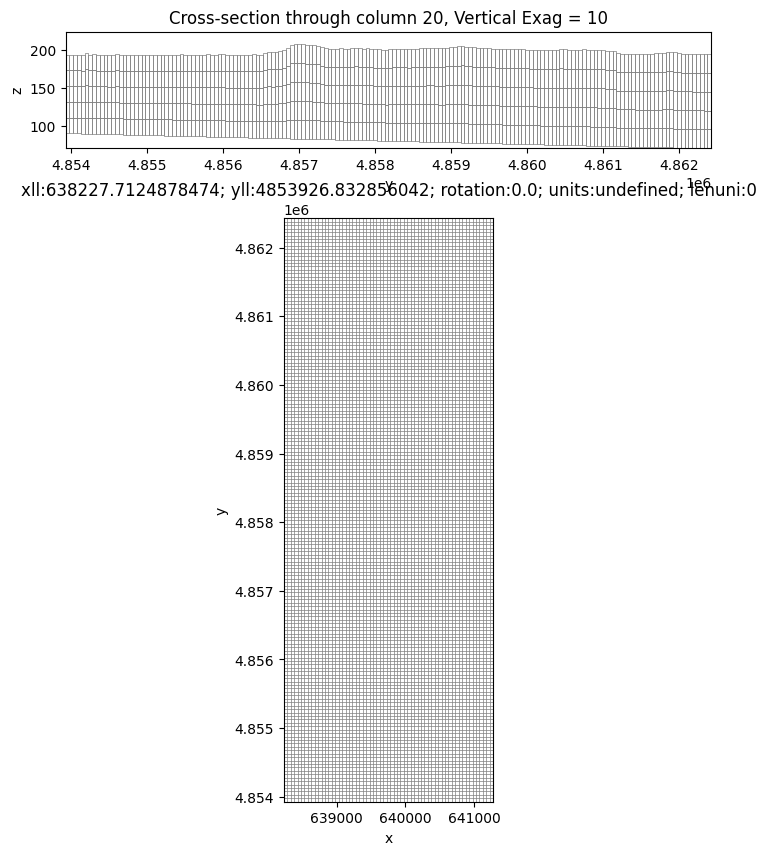

In [40]:
combined_gridplot(modelgrid,cross_type="column", cross_num=20,vert_exag=10)